In [7]:
import matplotlib.pyplot as plt 
import numpy as np 
import json 

In [8]:
lanl = '../pretrained/rw_sampling/lanl14argus/rw_bert_lanl14argus_log_tiny.txt'
optc = '../pretrained/rw_sampling/optc_e8/rw_bert_optc_log_tiny.txt'
unsw = '../pretrained/rw_sampling/unsw_e8/rw_bert_unsw_log_tiny.txt'

In [9]:
mean = lambda x : sum(x) / len(x) 

def get_times(fn, regularize=False):
    with open(fn,'r') as f:
        data = f.read()
    
    ts = []
    for line in data.split('\n'): 
        if not line: 
            continue 

        tokens = line.split(',')
        t = tokens[-1]
        ts.append(float(t))

    # Accidentally timed evaluation steps for some of them
    mu = mean(ts)
    real_mu = []
    to_update = []
    if regularize: 
        for i in range(len(ts)): 
            if ts[i] > 2*mu: 
                to_update.append(i) 
            else: 
                real_mu.append(ts[i])

        real_mu = mean(real_mu)
        for i in to_update: 
            ts[i] = real_mu
            
    return ts 

optc_pretrain = sum(get_times(optc, regularize=True))
lanl_pretrain = sum(get_times(lanl))
unsw_pretrain = sum(get_times(unsw, regularize=True))


In [10]:
fts = [0,0,0]

for i,ds in enumerate(['lanl', 'optc', 'unsw']): 
    f = f'../latency/latency_{ds}_ft.json'
    with open(f, 'r') as f_:
        data = json.load(f_)
    
    for k,v in data.items(): 
        fts[i] += sum(v)

lanl_ft,optc_ft,unsw_ft = fts

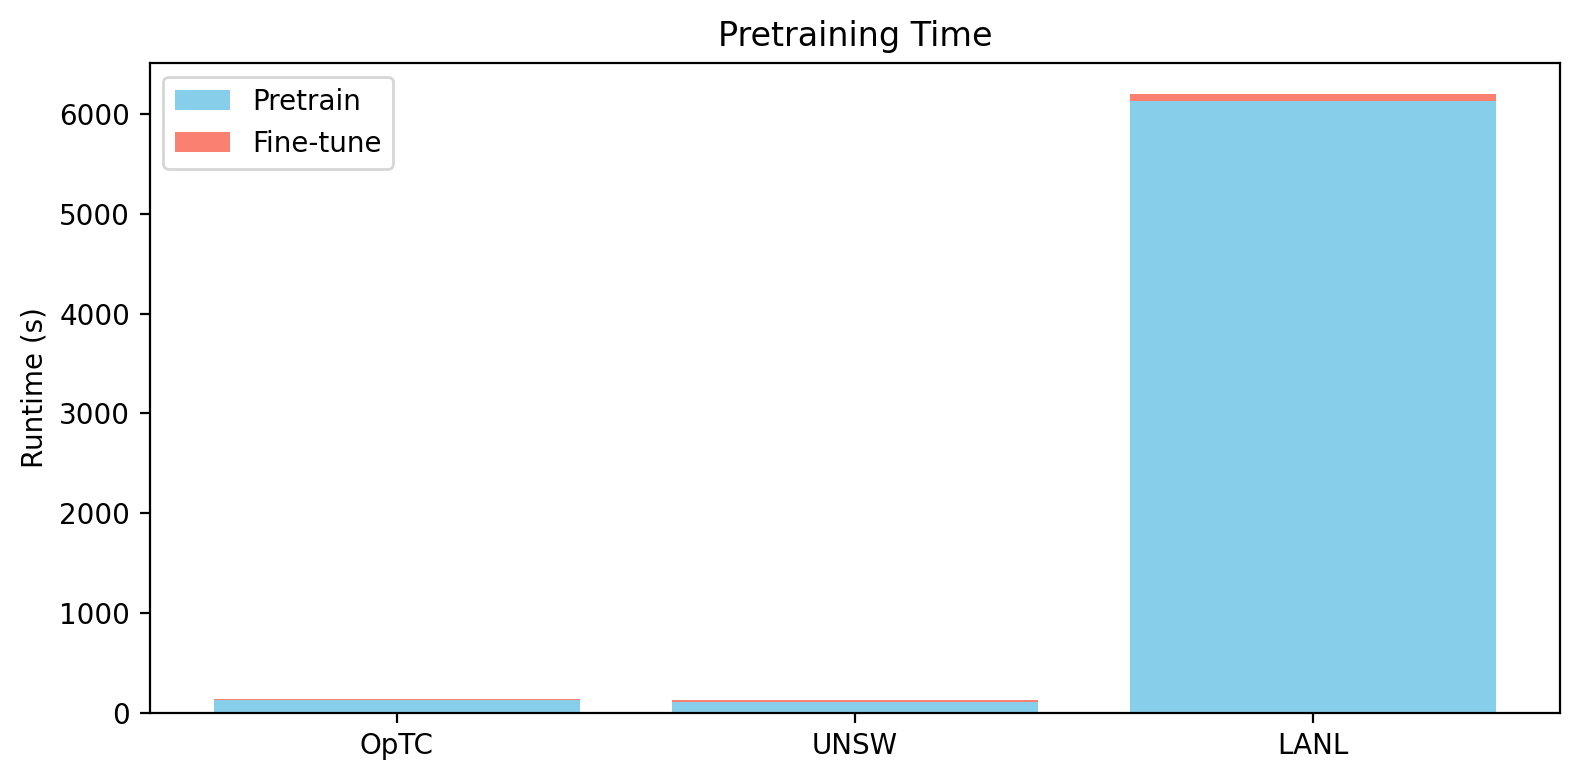

In [11]:
# Extract data
datasets = ['OpTC', 'UNSW', 'LANL']
stacked_values = {
    'Pretrain': [optc_pretrain, unsw_pretrain, lanl_pretrain],
    'Fine-tune': [optc_ft, unsw_ft, lanl_ft]
}

# The categories for stacking
colors = ['skyblue', 'salmon']

# Plot
x = np.arange(3)
plt.figure(figsize=(8, 4), dpi=200)

bottom = np.zeros(3)
for i,part in enumerate(stacked_values):
    plt.bar(x, stacked_values[part], bottom=bottom, label=part, color=colors[i])
    bottom += stacked_values[part]

plt.xticks(x, datasets)
plt.ylabel("Runtime (s)")
plt.title("Pretraining Time")
plt.legend()

plt.tight_layout()
plt.show()

{'Pretrain': [0, 0, 0, 0, 130.44633768917475], 'Fine-tune': [0, 0, 0, 0, 5.412588596343994], '': [4.9797258377075195, 15.097932815551758, 366.18285369873047, 272.7681493759155, 0]}
optc


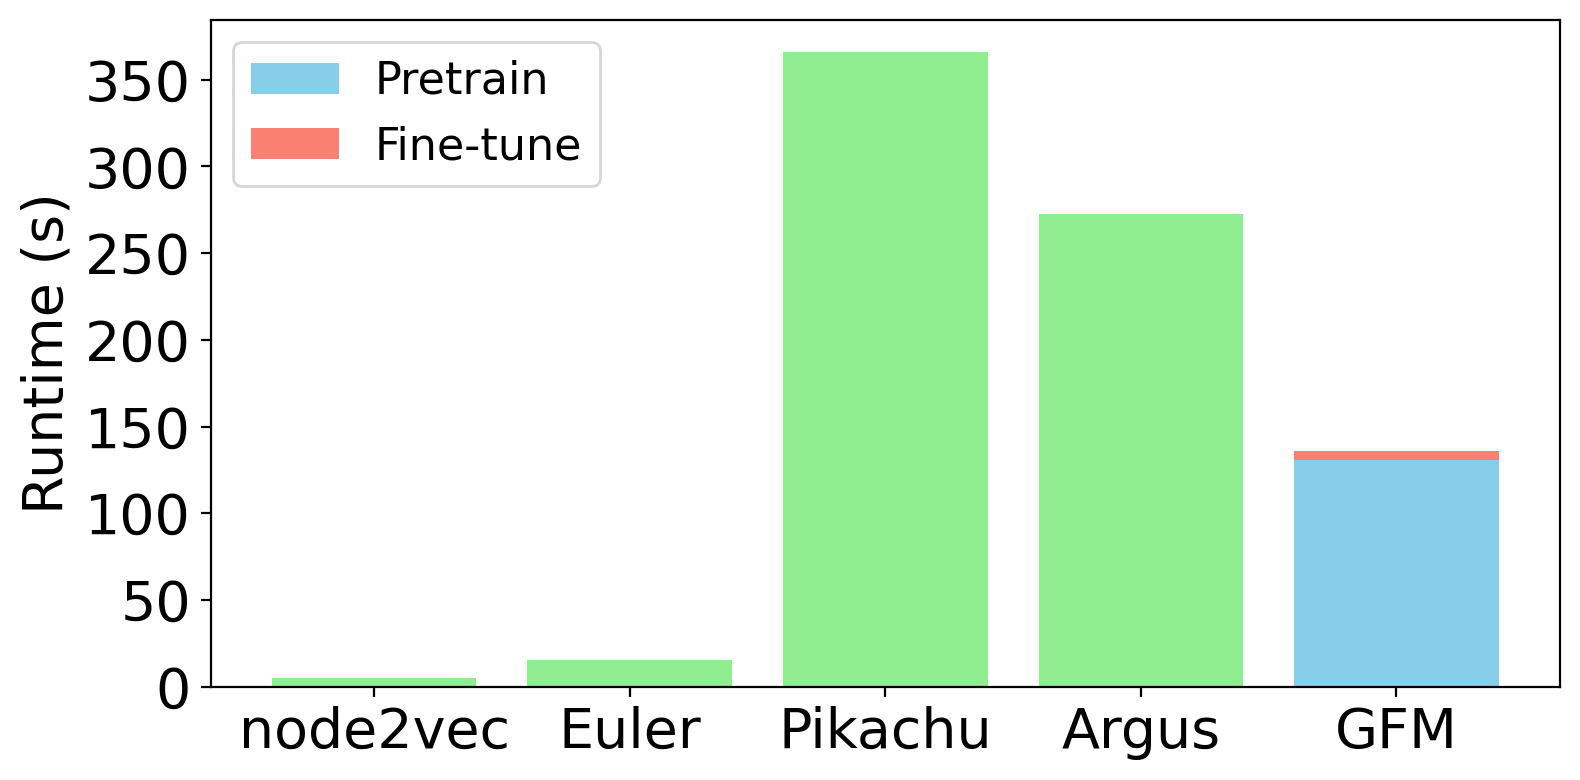

{'Pretrain': [0, 0, 0, 0, 109.34235920238118], 'Fine-tune': [0, 0, 0, 0, 17.18809413909912], '': [2.572565793991089, 36.81603670120239, 98.61494040489197, 105.35850048065186, 0]}
unsw


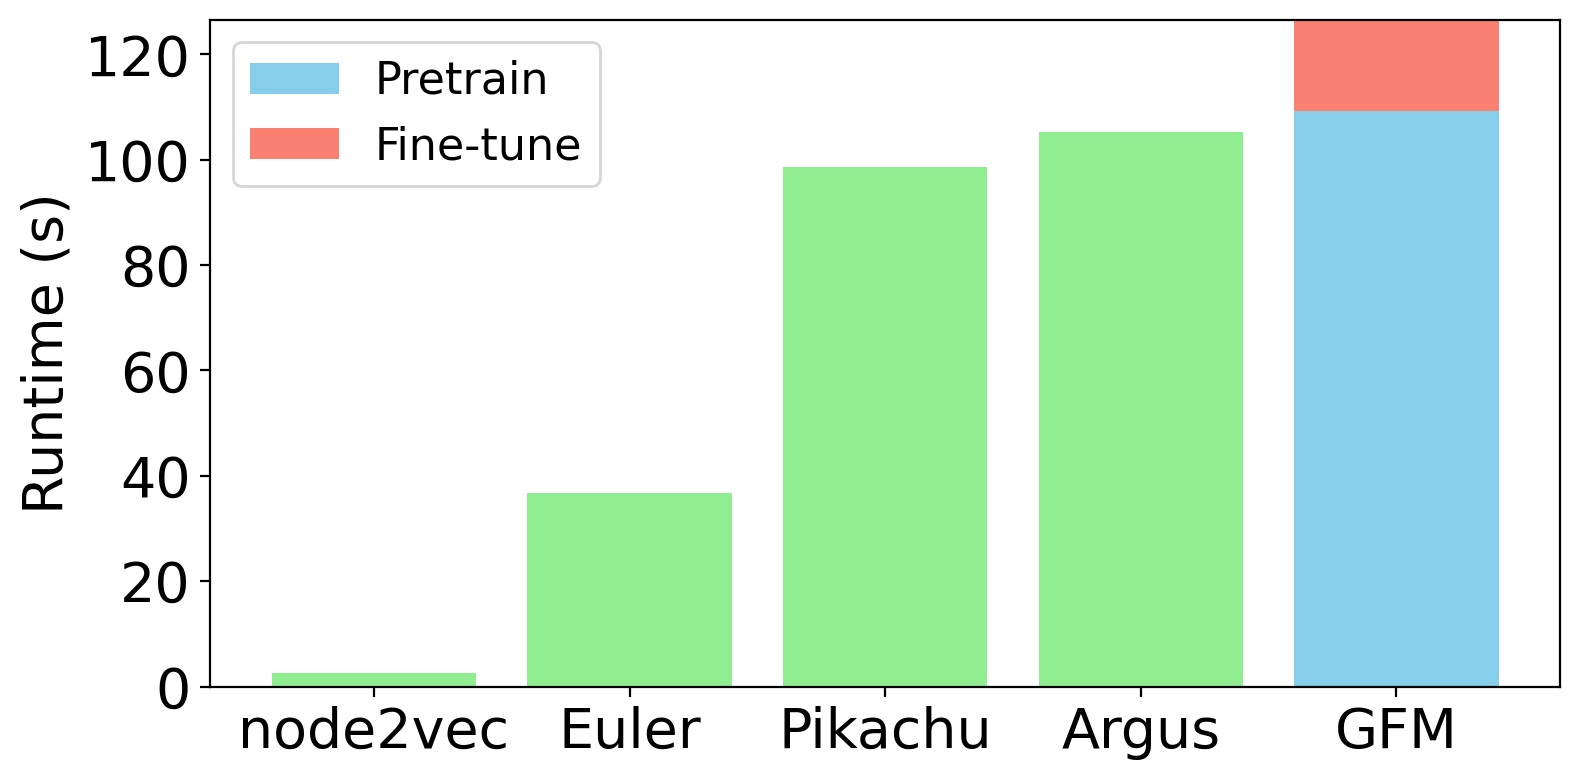

{'Pretrain': [0, 0, 0, 0, 6137.303785562515], 'Fine-tune': [0, 0, 0, 0, 70.0703935623169], '': [42.86733031272888, 94.92548704147339, 3390.222097635269, 8415.596096515656, 0]}
lanl


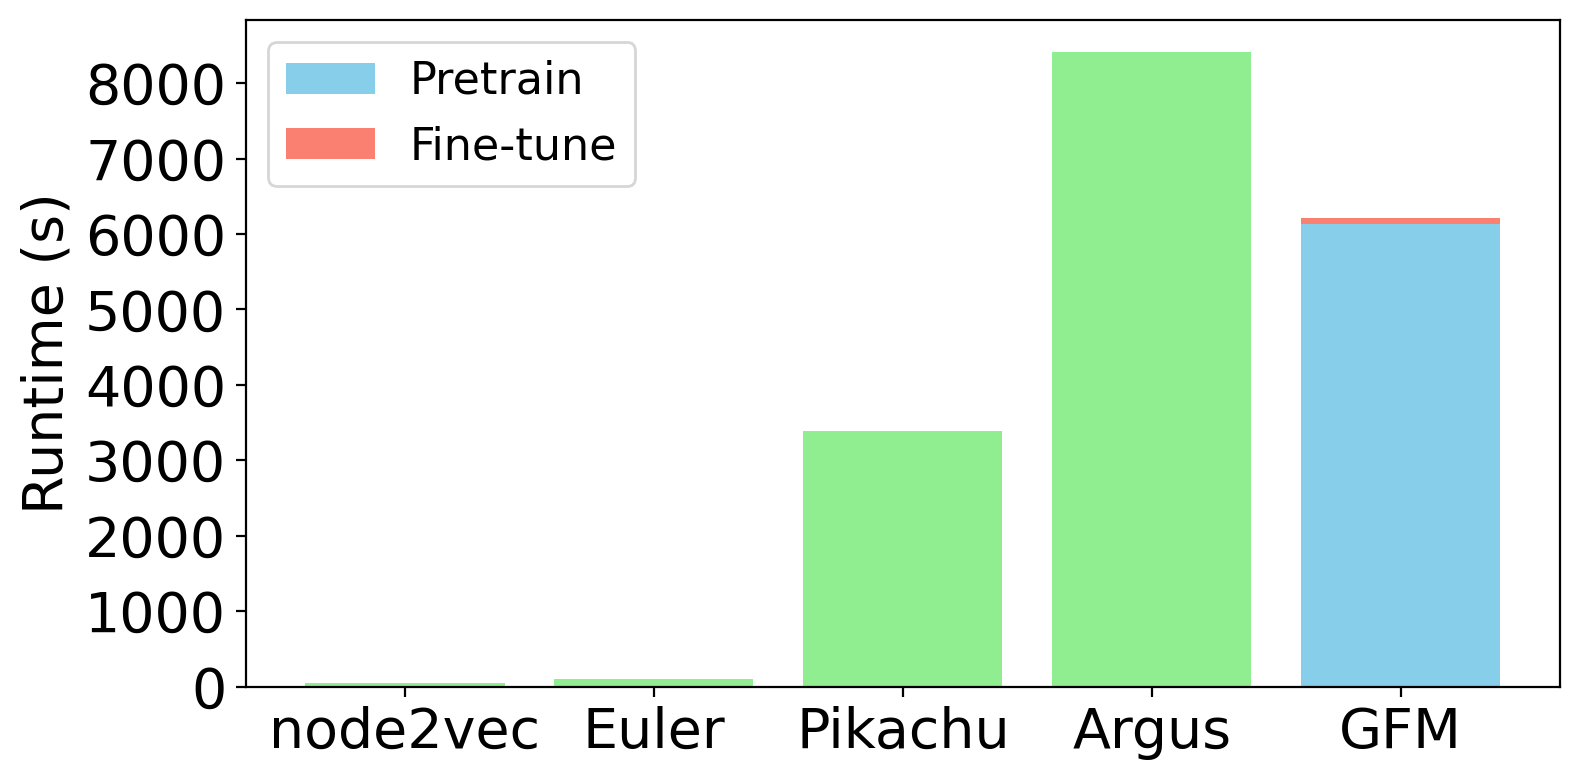

In [12]:
finetune_epochs = {'Euler': 15, 'Argus': 10, 'GFM': 5, 'Pikachu': 1, 'node2vec': 1}
gfm_times = {
    'optc': [optc_pretrain, optc_ft], 
    'unsw': [unsw_pretrain, unsw_ft],
    'lanl': [lanl_pretrain, lanl_ft]
}

for ds in ['optc', 'unsw', 'lanl']:
    models = []
    times = []
    with open(f'../latency/comparison/{ds}_latencies.csv', 'r') as f: 
        line = f.readline() 
        while line: 
            tokens = line.split(',')
            model = tokens[0]
            models.append(model)

            ts =  [float(t) for t in tokens[1:]]
            
            if model == 'GFM': 
                t = [*gfm_times[ds], 0]
            else: 
                t = [0,0, sum(ts) * finetune_epochs[model]]

            times.append(t)
            line = f.readline()

    labels = ['Pretrain', 'Fine-tune', '']
    colors = ['skyblue', 'salmon', 'lightgreen']#, 'orange', 'mediumpurple']

    # Build stacked values (proportion * total)
    stacked_values = {part: [r[i] for r in times] for i,part in enumerate(labels)}
    print(stacked_values)

    # Plot
    x = np.arange(len(models))
    plt.figure(figsize=(8, 4), dpi=200)

    bottom = np.zeros(len(models))
    for i,part in enumerate(labels):
        plt.bar(x, stacked_values[part], bottom=bottom, label=labels[i], color=colors[i])
        bottom += stacked_values[part]

    plt.xticks(x, models, size=20)
    plt.yticks(size=20)
    plt.ylabel("Runtime (s)", size=20)
    #plt.title(f"Training Time per Epoch ({ds.upper().replace('P', 'p')})")
    plt.legend(fontsize=16, loc='upper left')

    plt.tight_layout()
    print(ds)
    plt.show()